In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from pandas.plotting import scatter_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Read in and basic overview

In [56]:
# Read csv dataset
path_dataset = 'gdrive/My Drive/CS109BProject/data/QA-0815X.xlsx'
qa_df = pd.read_excel(path_dataset,  sheet_name=2)
df = pd.DataFrame()
df['PID'] = qa_df['Project No. ']
df['Project_Completion_Date'] = qa_df['Final Inspection ']
df['Project_Schedule_Changes'] = qa_df['Final Inspection '] - qa_df['Scheduled Completion Date ']
df['Project_Start_Date'] = qa_df['Title Request ']
#df['Design_Completion_Date'] = qa_df['Design Actual Completion Date ']
#df['Design_Schedule_Changes'] = qa_df['Design Actual Completion Date '] - qa_df['Design Schedule and Completion Date']
df['Total_Budget'] = qa_df['Total Budget']
df['Budget_Changes'] = qa_df['Total Budget'] - qa_df['Construction Registered Amount ']
df['Category'] = qa_df['Construction Unit']
df.replace('', np.nan, inplace=True)
df = df.dropna()
df.reset_index(drop=True, inplace=True)
df.describe(include='all')

,PID,Project_Completion_Date,Project_Schedule_Changes,Project_Start_Date,Total_Budget,Budget_Changes,Category
count,1787,1787,1787,1787,1.787000e+03,1.787000e+03,1787
unique,1787,1109,NaN,835,NaN,NaN,38
top,XG-199,2000-05-12 00:00:00,NaN,1999-04-09 00:00:00,NaN,NaN,T
freq,1,9,NaN,35,NaN,NaN,245
first,NaN,1998-01-07 00:00:00,NaN,1986-12-18 00:00:00,NaN,NaN,NaN
last,NaN,2008-04-01 00:00:00,NaN,2008-03-11 00:00:00,NaN,NaN,NaN
mean,NaN,NaN,78 days 08:16:23.100167,NaN,8.841935e+05,2.594346e+05,NaN
std,NaN,NaN,190 days 17:52:24.639645,NaN,1.480512e+06,7.025884e+05,NaN
min,NaN,NaN,-992 days +00:00:00,NaN,7.000000e+03,-6.590000e+05,NaN
25%,NaN,NaN,-7 days +00:00:00,NaN,2.915000e+05,4.163750e+04,NaN


In [57]:
df.dtypes

PID                                  object
Project_Completion_Date      datetime64[ns]
Project_Schedule_Changes    timedelta64[ns]
Project_Start_Date           datetime64[ns]
Total_Budget                          int64
Budget_Changes                      float64
Category                             object
dtype: object

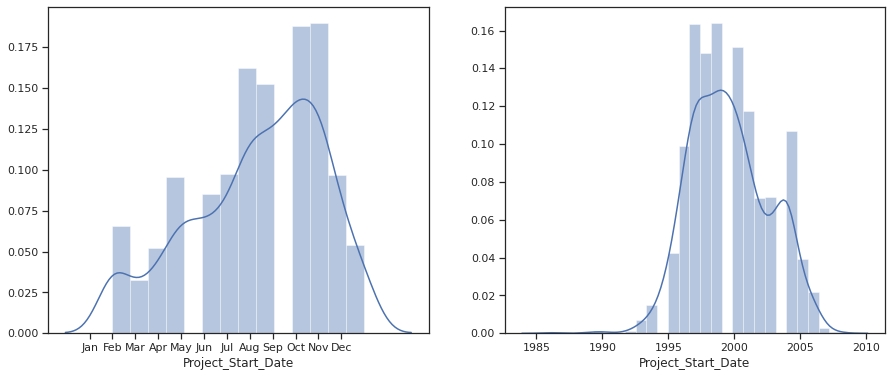

MIN Day = 1986-12-18 00:00:00
MAX Day = 2008-04-01 00:00:00


In [60]:
#### (1) #### Project Start by Month and Year
df_Month = df['Project_Start_Date'].dt.month
df_Year = df['Project_Start_Date'].dt.year
month_ticks = {0:'Jan', 1:'Feb',2:'Mar',3:'Apr',4:'May',5:'Jun',6:'Jul',7:'Aug',8:'Sep',9:'Oct',10:'Nov',11:'Dec'}
fig, axes = plt.subplots(1,2, figsize=(15,6))
sns.distplot(df_Month, ax=axes[0])
axes[0].set_xticks(list(month_ticks.keys()))
axes[0].set_xticklabels(list(month_ticks.values()))
sns.distplot(df_Year,ax=axes[1])
plt.show()

DT_MIN_DAY = min(df['Project_Start_Date'])
DT_MAX_DAY = max(df['Project_Completion_Date'])
print(f'MIN Day = {DT_MIN_DAY}\nMAX Day = {DT_MAX_DAY}')

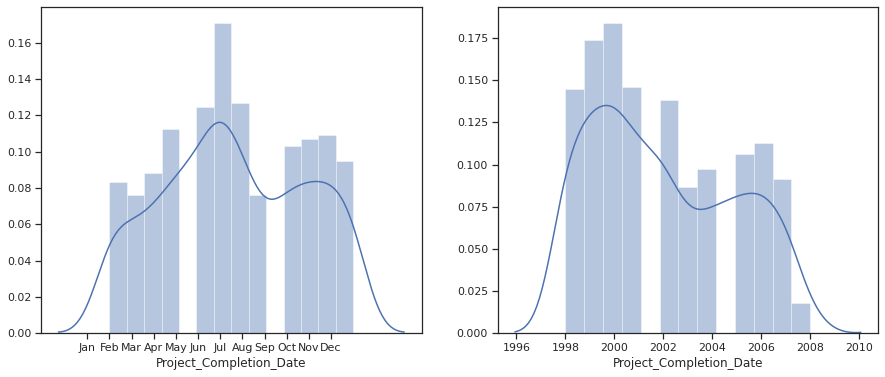

MIN Day = 1986-01-01 00:00:00
MAX Day = 2009-01-01 00:00:00


In [62]:
#### (1) #### Project Completion by Month and Year
df_Month = df['Project_Completion_Date'].dt.month
df_Year = df['Project_Completion_Date'].dt.year
month_ticks = {0:'Jan', 1:'Feb',2:'Mar',3:'Apr',4:'May',5:'Jun',6:'Jul',7:'Aug',8:'Sep',9:'Oct',10:'Nov',11:'Dec'}
fig, axes = plt.subplots(1,2, figsize=(15,6))
sns.distplot(df_Month, ax=axes[0])
axes[0].set_xticks(list(month_ticks.keys()))
axes[0].set_xticklabels(list(month_ticks.values()))
sns.distplot(df_Year,ax=axes[1])
plt.show()

DT_MIN_DAY = pd.to_datetime('19860101', format='%Y%m%d')
DT_MAX_DAY = pd.to_datetime('20090101', format='%Y%m%d')
print(f'MIN Day = {DT_MIN_DAY}\nMAX Day = {DT_MAX_DAY}')

In [63]:
# Change datetime to numeric
df['Project_Completion_Date'] = pd.to_numeric((df['Project_Completion_Date'].copy() - DT_MIN_DAY)/pd.Timedelta(days=1))
df['Project_Start_Date'] = pd.to_numeric((df['Project_Start_Date'].copy() - DT_MIN_DAY)/pd.Timedelta(days=1))
df['Project_Schedule_Changes'] = df['Project_Schedule_Changes']/pd.Timedelta(days=1)
df.dtypes

PID                          object
Project_Completion_Date     float64
Project_Schedule_Changes    float64
Project_Start_Date          float64
Total_Budget                  int64
Budget_Changes              float64
Category                     object
dtype: object

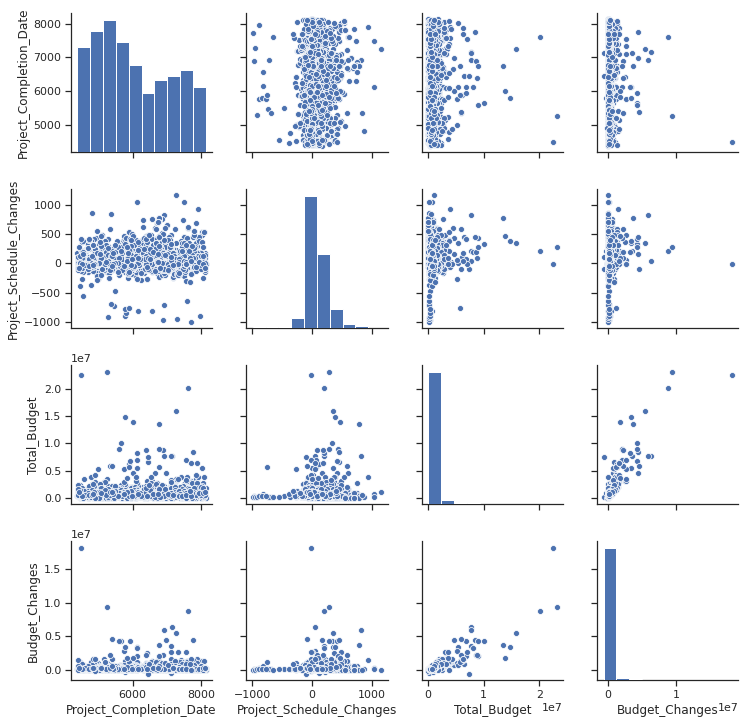

In [65]:
sns.set(style="ticks")
qual_columns = ['Project_Completion_Date', 'Project_Schedule_Changes', 'Total_Budget', 'Budget_Changes']	
sns.pairplot(df[qual_columns])

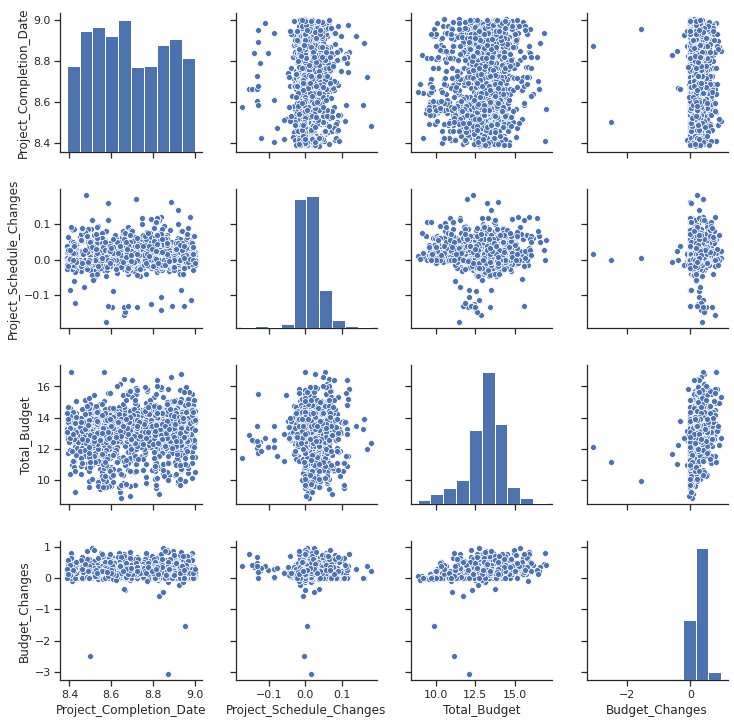

In [72]:
reg_df = df.copy()
reg_df['Project_Schedule_Changes'] = df['Project_Schedule_Changes']/df['Project_Completion_Date']
reg_df['Budget_Changes'] = df['Budget_Changes']/df['Total_Budget']
reg_df['Total_Budget'] = np.log(df['Total_Budget'])
reg_df['Project_Completion_Date'] = np.log(df['Project_Completion_Date'])
sns.pairplot(reg_df[qual_columns])

## Regression Model

In [74]:
####  (4)  #### Handle Categorical Columns using dummy variables
categorical_columns = ['Category'] # not including Agencies nor Decription
#nyc_df = reg_pd.get_dummies(df, columns=categorical_columns, drop_first=True)
nyc_df = reg_df.copy()

#### (5) #### Drop redundant or useless columns, and drop NaNs
drop_columns = ['PID', 'Category']
nyc_df = nyc_df.drop(drop_columns, axis=1)
nyc_df.describe(include='all')

,Project_Completion_Date,Project_Schedule_Changes,Project_Start_Date,Total_Budget,Budget_Changes
count,1787.000000,1787.000000,1787.000000,1787.000000,1787.000000
mean,8.689316,0.012941,5176.421377,13.097393,0.227950
std,0.174907,0.030679,1071.751273,1.166007,0.199773
min,8.386857,-0.173404,351.000000,8.853665,-3.062861
25%,8.544808,-0.001142,4319.000000,12.582794,0.120161
50%,8.673684,0.007130,5028.000000,13.281075,0.228892
75%,8.849371,0.024889,5909.000000,13.780919,0.313812
max,9.002824,0.179120,8105.000000,16.956079,0.970213


In [0]:
nyc_df = nyc_df.dropna()
nyc_train, nyc_test = train_test_split(nyc_df, test_size=.2, random_state=90)

In [76]:
nyc_train.head()

,Project_Completion_Date,Project_Schedule_Changes,Project_Start_Date,Total_Budget,Budget_Changes
407,8.760453,-0.009566,5593.0,13.551545,3.645833e-02
1246,8.743851,0.029974,5593.0,13.071070,1.578947e-01
320,8.827321,-0.005427,6040.0,11.695247,-5.833333e-01
1437,8.997642,0.065933,5693.0,12.588562,-6.821608e-07
1648,8.923458,0.004663,6950.0,14.052162,3.509457e-01


In [77]:
nyc_train[qual_columns].corr()

,Project_Completion_Date,Project_Schedule_Changes,Total_Budget,Budget_Changes
Project_Completion_Date,1.000000,0.002578,0.090657,-0.035287
Project_Schedule_Changes,0.002578,1.000000,0.024196,0.033881
Total_Budget,0.090657,0.024196,1.000000,0.380361
Budget_Changes,-0.035287,0.033881,0.380361,1.000000


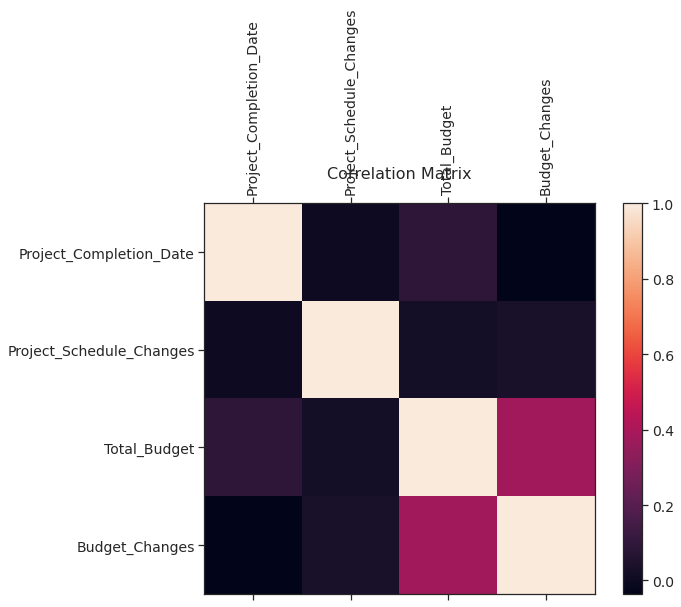

In [78]:
f = plt.figure(figsize=(10, 7))
plt.matshow(nyc_train[qual_columns].corr(), fignum=f.number)
plt.xticks(range(len(qual_columns)), qual_columns, fontsize=14, rotation=90)
plt.yticks(range(len(qual_columns)), qual_columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [104]:
# Budget change
# Project_Completion_Date	Project_Schedule_Changes	Total_Budget	Budget_Changes
nyc_train_trunc = nyc_train.copy()
nyc_train_trunc = nyc_train_trunc[qual_columns]
y_train = nyc_train_trunc['Budget_Changes']
X_train = nyc_train_trunc.drop(['Budget_Changes','Project_Schedule_Changes'], axis=1)
#poly = PolynomialFeatures(interaction_only=True,include_bias = False)
#X_train = poly.fit_transform(X_train)
fitted_model = LinearRegression().fit(X_train, y_train)
fitted_model.score(X_train, y_train)

0.1495828614200717

In [105]:
X_train = sm.add_constant(X_train)
results = OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Budget_Changes   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     125.4
Date:                Tue, 05 May 2020   Prob (F-statistic):           6.72e-51
Time:                        19:25:30   Log-Likelihood:                 478.99
No. Observations:                1429   AIC:                            -952.0
Df Residuals:                    1426   BIC:                            -936.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0800      0.230      0.348      0.728      -0.370       0.530
Project_Completion_Date    -0.0755      0.026     -2.869      0.004      -0.127      -0.024
Total_Budget                0.0613      0.004     15.771      0.000       0.054       0.069
==============================================================================
Omnibus:                      935.100   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           103226.625
Skew:                          -2.147   Prob(JB):                         0.00
Kurtosis:                      44.416   Cond. No.                         795.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

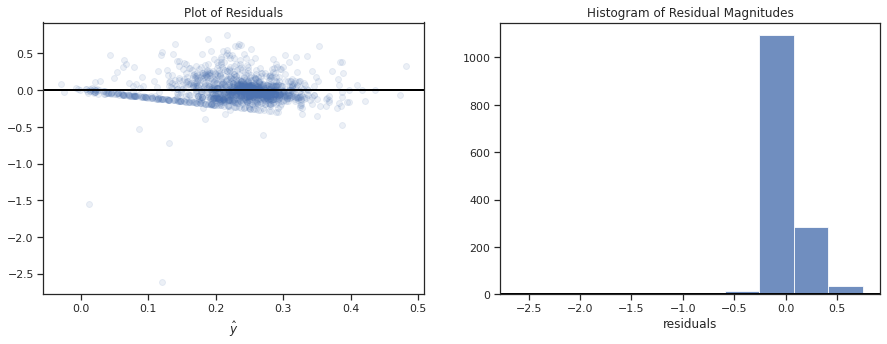

In [106]:
# Residual Plots
y_hat_train = results.predict()
residuals = (y_train - y_hat_train)
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].set_title('Plot of Residuals')
axes[0].scatter((y_hat_train), residuals, alpha=0.1)
axes[0].axhline(0, c='black', lw=2)
axes[0].set_xlabel(r'$\hat{y}$')
axes[1].set_title('Histogram of Residual Magnitudes')
axes[1].hist(residuals, alpha=0.8)
axes[1].axhline(0, c='black', lw=2)
axes[1].set_xlabel(r'residuals')
plt.show()


In [109]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.Series([variance_inflation_factor(X_train.values, i) 
               for i in range(X_train.shape[1])], 
               index=X_train.columns)

const                      2510.417286
Project_Completion_Date       1.008287
Total_Budget                  1.008287
dtype: float64

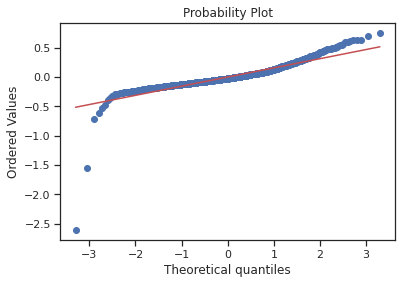

In [110]:
import pylab 
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()

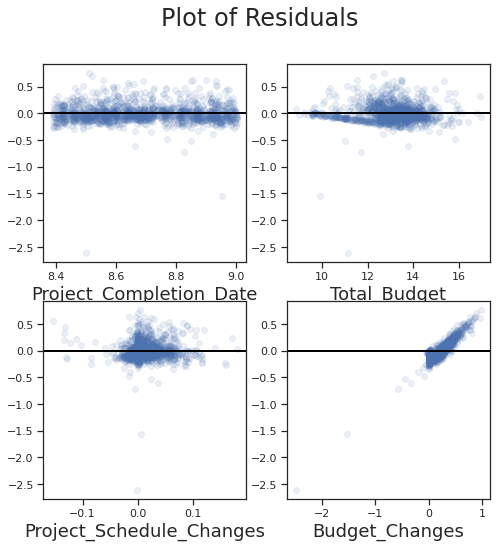

In [111]:
# Residual Plots
y_hat_train = results.predict()
residuals = y_train - y_hat_train

fig, axes = plt.subplots(2,2,figsize=(8,8))
fig.suptitle('Plot of Residuals', fontsize=24)
for i in range(4):
  x_val = y_hat_train
  x_lbl = r'$\hat{y}$'
  if i > -1:
    x_val = nyc_train[qual_columns[i]].ravel()
    x_lbl = qual_columns[i]
  row_idx = np.mod(i,2)
  col_idx = int(i / 2) 
  axes[row_idx][col_idx].scatter(x_val, residuals, alpha=0.1)
  axes[row_idx][col_idx].axhline(0, c='black', lw=2)
  axes[row_idx][col_idx].set_xlabel(x_lbl, fontsize=18)
plt.show()

In [185]:
# Cost change
# Project_Completion_Date	Project_Schedule_Changes	Total_Budget	Budget_Changes
nyc_train_trunc = nyc_train.copy()
nyc_train_trunc = nyc_train_trunc[qual_columns]
y_train = (nyc_train_trunc['Project_Schedule_Changes'])
X_train = nyc_train_trunc.drop(['Project_Schedule_Changes', 'Project_Completion_Date', 'Total_Budget'], axis=1)
#X_train['Project_Completion_Date'] = np.exp(X_train['Project_Completion_Date'])
#X_train['Total_Budget'] = np.exp(X_train['Total_Budget'])
#poly = PolynomialFeatures(interaction_only=True,include_bias = False)
#X_train = poly.fit_transform(X_train)
fitted_model = LinearRegression().fit(X_train, y_train)
fitted_model.score(X_train, y_train)

0.001147955382778676

In [186]:
X_train = sm.add_constant(X_train)
results = OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     Project_Schedule_Changes   R-squared:                       0.001
Model:                                  OLS   Adj. R-squared:                  0.000
Method:                       Least Squares   F-statistic:                     1.640
Date:                      Tue, 05 May 2020   Prob (F-statistic):              0.201
Time:                              19:49:16   Log-Likelihood:                 2974.7
No. Observations:                      1429   AIC:                            -5945.
Df Residuals:                          1427   BIC:                            -5935.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0127      0.001     10.120      0.000       0.010       0.015
Budget_Changes     0.0055      0.004      1.281      0.201      -0.003       0.014
==============================================================================
Omnibus:                      220.696   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1805.213
Skew:                           0.456   Prob(JB):                         0.00
Kurtosis:                       8.430   Cond. No.                         5.61
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [187]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.Series([variance_inflation_factor(X_train.values, i) 
               for i in range(X_train.shape[1])], 
               index=X_train.columns)

const             2.448989
Budget_Changes    1.000000
dtype: float64

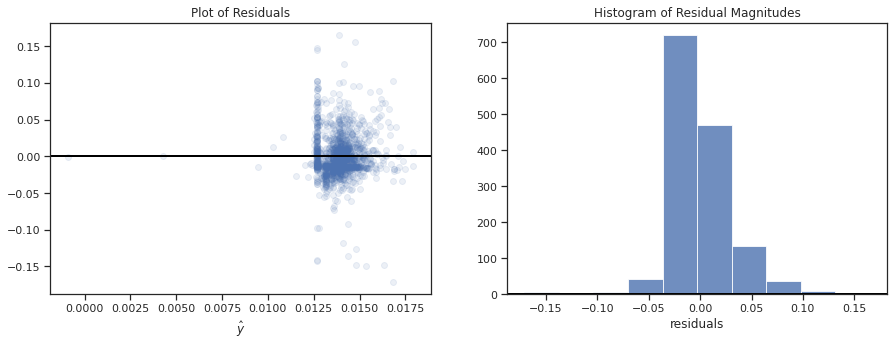

In [188]:
# Residual Plots
y_hat_train = results.predict()
residuals = y_train - y_hat_train
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].set_title('Plot of Residuals')
axes[0].scatter(y_hat_train, residuals, alpha=0.1)
axes[0].axhline(0, c='black', lw=2)
axes[0].set_xlabel(r'$\hat{y}$')
axes[1].set_title('Histogram of Residual Magnitudes')
axes[1].hist(residuals, alpha=0.8)
axes[1].axhline(0, c='black', lw=2)
axes[1].set_xlabel(r'residuals')
plt.show()

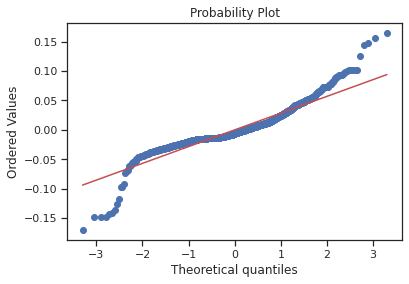

In [189]:
import pylab 
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()
plt.show()

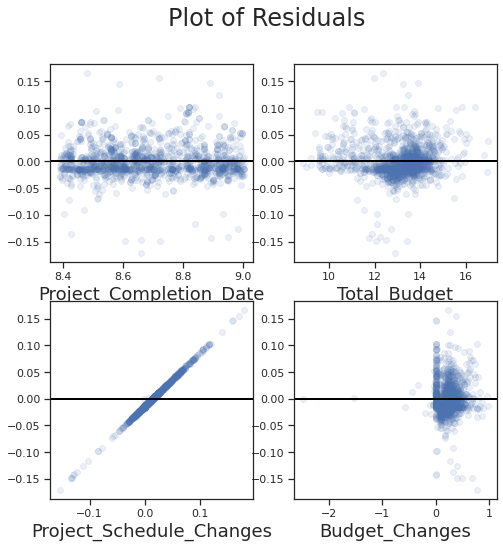

In [190]:
# Residual Plots
y_hat_train = results.predict()
residuals = y_train - y_hat_train

fig, axes = plt.subplots(2,2,figsize=(8,8))
fig.suptitle('Plot of Residuals', fontsize=24)
for i in range(4):
  x_val = y_hat_train
  x_lbl = r'$\hat{y}$'
  if i > -1:
    x_val = nyc_train[qual_columns[i]].ravel()
    x_lbl = qual_columns[i]
  row_idx = np.mod(i,2)
  col_idx = int(i / 2) 
  axes[row_idx][col_idx].scatter(x_val, residuals, alpha=0.1)
  axes[row_idx][col_idx].axhline(0, c='black', lw=2)
  axes[row_idx][col_idx].set_xlabel(x_lbl, fontsize=18)
plt.show()